# Steps


1. Read the data from the csv file
2. Read the sequences from the pkl file
3. Compute the covariances
4. Order their rows/columns

In [1]:
%matplotlib inline
import time
import os
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import numpy.ma as ma
import pickle
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter

In [2]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

def get_corr_subset(corr_mat, shape, i, j):
    shape = np.insert(shape, 0, 0)
    cum_shape = np.cumsum(shape)
    i_ind = (cum_shape[i+1], cum_shape[i])[::-1]
    j_ind = (cum_shape[j+1], cum_shape[j])[::-1]
    subset = corr_mat[i_ind[0]:i_ind[1],j_ind[0]:j_ind[1]]
    if i == j:
        tril = np.tril_indices(subset.shape[0],-1)
        subset_vec = subset[tril]
    else:
        subset_vec = subset.flatten()
    return subset_vec

def get_corr_mat(X_df, dx_list, viscode, subtype, select_cols, sequence):
    X_f = X_df[X_df["VISCODE"]==viscode]
    X_f = X_f[X_f["subtype"]==subtype]
    X_f = X_f[X_f["DX"].isin(dx_list)]
    X_f = X_f.iloc[:,select_cols].values[:,sequence]
    corr = np.corrcoef(X_f.T)
    n = X_f.shape[0]
    return corr, n

def plot_corr_mat(corr_mat, shape_seq, viscode, n, save_path, name, vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(corr_mat, vmin=vmin, vmax=vmax, center=0, cmap=cmap, ax=ax, square=False)
    ax.hlines(np.cumsum(shape_seq), 0, sum(shape_seq), color='k', linestyle="--", linewidth=3)
    ax.vlines(np.cumsum(shape_seq), 0, sum(shape_seq), color='k', linestyle="--", linewidth=3)
    ax.set_title("Correlation matrix\n(visit={}, n={})".format(viscode,n), fontsize=15)
    ax.set_xlabel("Biomarker index", fontsize=15)
    ax.set_ylabel("Biomarker index", fontsize=15)
    fig_path = os.path.join(save_path, name + ".png")
    fig.savefig(fig_path, dpi=400)
    return fig, ax

In [3]:
cn_ad_path = "/home/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm_final_n327.csv"
df_cnad = pd.read_csv(cn_ad_path)

In [4]:
# Get the mixture model for the CN/AD subjects
k=119
X_mm = df_cnad.iloc[:,:k].values
bm_names = df_cnad.iloc[:,:k].columns.tolist()
y_mm = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X_mm, y_mm)

/home/rtandon32/.conda/envs/sustain/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [5]:
# read the all data
all_df_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_all_aligned.csv"
all_df = pd.read_csv(all_df_path)

In [6]:
# Re-order the columns so the are in the same order as the mixture_model object
demo_cols = all_df.columns.difference(bm_names)
df_demo = all_df[demo_cols]
df_bm = all_df[bm_names]
all_df = pd.concat([df_bm, df_demo], axis=1)
assert bm_names == all_df.columns.tolist()[:k]

In [7]:
# Set the columns which have to be excluded/included in the analysis. 
# if all columns are to be included, set exclude_idx to empty list
exclude_idx = [21,  71,  22,  19, 111,  64,  96,  44,  90,  50,  80,  57,   9,
            77,  33, 113,  76,  98, 105,  79,  41,   4,  87, 107, 114,  20,
             2, 110,  84,  23,  58,   1,  60,  56,  10,  94,  49,  74,   0,
            92,  91,  18,  61,  43,  45, 108,  78, 118,  62,   8,   5,  46,
             3,  47,  48,  53,  42, 112,  73]
# exclude_idx = []
select_cols = [_ for _ in range(k) if _ not in exclude_idx]
X_all = all_df.iloc[:,select_cols]
X_all = X_all.values
y = all_df["DX"].map({"Dementia":1, "CN":0, "MCI":2})

In [8]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole14_mixture_GMM/pickle_files/sim_tadpole14_subtype0.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [9]:
# Get the prob mat for the new subjects
prob_mat_all = mixture_model.get_prob_mat(X_all, [mixture_models[i] for i in select_cols])
L_no_all = prob_mat_all[:,:,0]
L_yes_all = prob_mat_all[:,:,1]
L_no_all = process_L(L_no_all)
L_yes_all = process_L(L_yes_all)

In [10]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [12,12,12,12,12]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 5
p_absorb = 0.3
N_em = 100
SuStaInLabels = [bm_names[i] for i in select_cols]
dataset_name            = 'sim_tadpole9_covar'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes_all, L_no_all, n_stages, stage_sizes, min_clust_size, p_absorb, 
                      rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, 
                      N_iterations_MCMC, N_em, output_folder, dataset_name, use_parallel_startpoints)

In [11]:
# Subtype and Stage all subjects
last_N = 1
N_samples = 1
sustainData_all = sEBMSustainData(L_yes_all, L_no_all, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,0]
samples_sequence = np.expand_dims(samples_sequence, axis=2)
samples_f = pkl["samples_f"][:,0].reshape(-1,1)
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_all, \
prob_ml_subtype_all, \
ml_stage_all, \
prob_ml_stage_all, \
prob_subtype_all, \
prob_stage_all, \
prob_subtype_stage_all,_ = sustain.subtype_and_stage_individuals(sustainData_all, shape_seq, samples_sequence, samples_f, N_samples)


In [12]:
# Add the subtypes and stages to the df columns
all_df["subtype"] = ml_subtype_all
all_df["stage"] = ml_stage_all

In [13]:
(samples_sequence == np.expand_dims(sustain._flatten_sequence(pkl["ml_sequence_EM"]), axis=2)).all()

True

In [14]:
seq = sustain._flatten_sequence(pkl["ml_sequence_EM"])
sort_idx = np.argsort(pkl["ml_f_EM"])[::-1]
seq = seq[sort_idx]
shape_seq = pkl["shape_seq"][sort_idx]

### Plot correlation matrices

In [15]:
dx_list = ["CN", "MCI", "Dementia"]
# dx_list = ["Dementia"]
subtype=0
sequence = seq[subtype]
shape = shape_seq[subtype]
corr_bl, n_bl = get_corr_mat(all_df, dx_list, "bl", subtype, select_cols, sequence)
corr_12, n_12 = get_corr_mat(all_df, dx_list, "m12", subtype, select_cols, sequence)
corr_24, n_24 = get_corr_mat(all_df, dx_list, "m24", subtype, select_cols, sequence)
corr_36, n_36 = get_corr_mat(all_df, dx_list, "m36", subtype, select_cols, sequence)

(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Correlation matrix\n(visit=m36, n=277)'}, xlabel='Biomarker index', ylabel='Biomarker index'>)

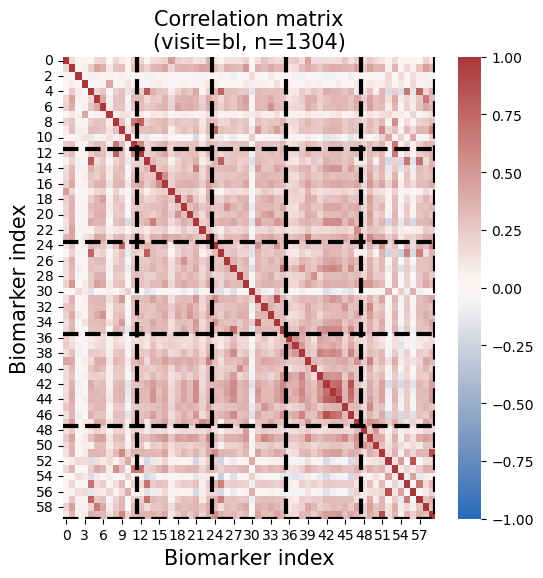

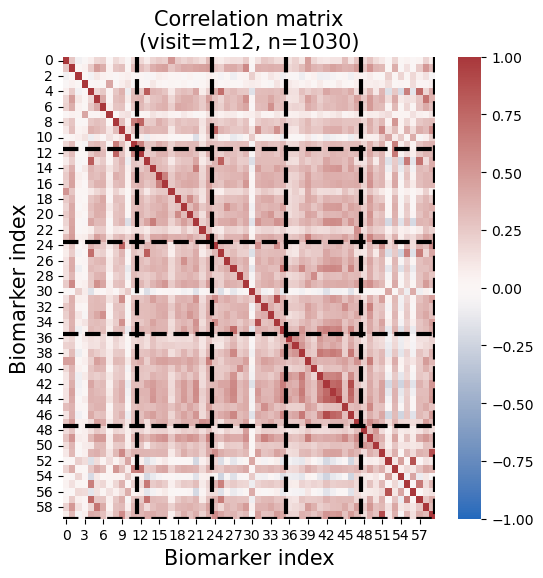

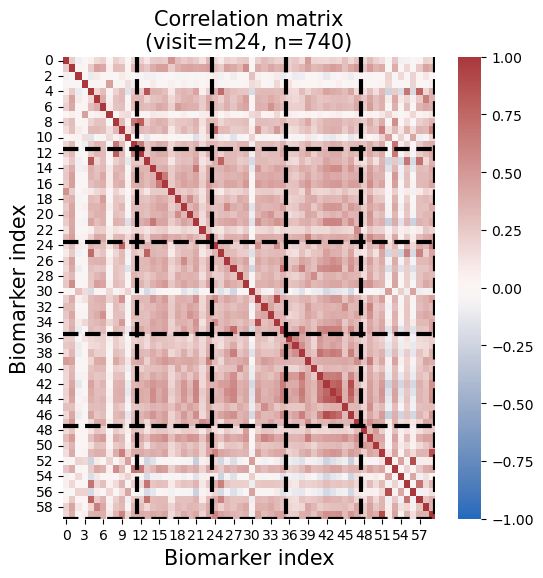

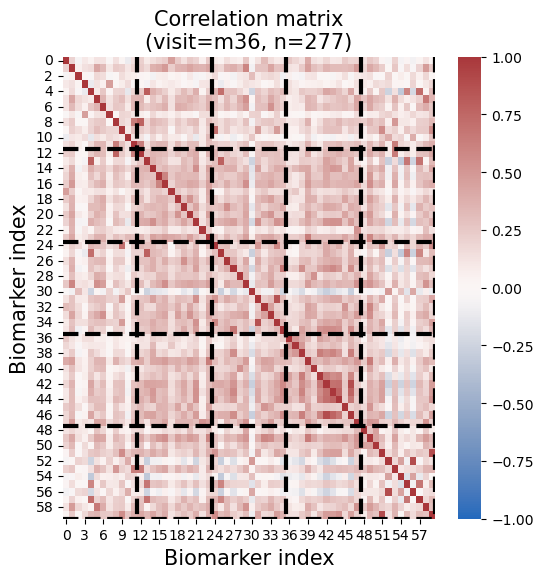

In [17]:
save_path = "/nethome/rtandon32/ebm/covar_analysis/tadpole14/"
plot_corr_mat(corr_bl, shape, "bl", n_bl, save_path, "subtype_{}_bl".format(subtype))
plot_corr_mat(corr_12, shape, "m12", n_12, save_path, "subtype_{}_m12".format(subtype))
plot_corr_mat(corr_24, shape, "m24", n_24, save_path, "subtype_{}_m24".format(subtype))
plot_corr_mat(corr_36, shape, "m36", n_36, save_path, "subtype_{}_m36".format(subtype))

In [18]:
n_bl, n_12, n_24, n_36

(1304, 1030, 740, 277)

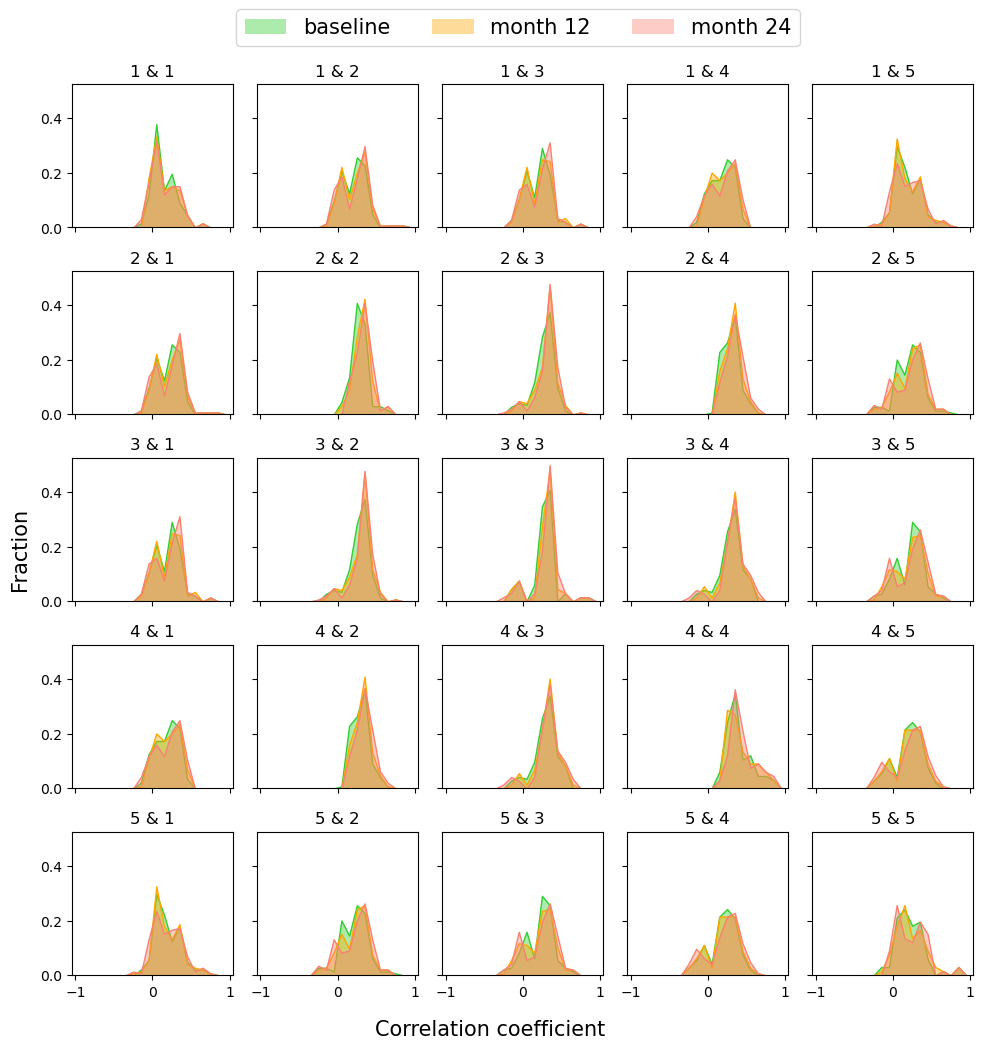

In [19]:
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True, sharey=True)
shape = shape_seq[subtype]
alpha=0.4
element_type = "poly"
linewidth=1.0
color = ["limegreen", "orange", "salmon"]
for i in range(5):
    for j in range(5):
        subset_vec_bl = get_corr_subset(corr_bl, shape, i, j)
        subset_vec_12 = get_corr_subset(corr_12, shape, i, j)
        subset_vec_24 = get_corr_subset(corr_24, shape, i, j)
        sns.histplot(subset_vec_bl, bins=20, ax = ax[i,j], 
                     binrange=(-1,1), stat="probability",
                    alpha=alpha, element=element_type, 
                    linewidth=linewidth, color = color[0])
        sns.histplot(subset_vec_12, bins=20, ax = ax[i,j], 
                     binrange=(-1,1), stat="probability",
                    alpha=alpha, element=element_type,
                    linewidth=linewidth, color = color[1])
        sns.histplot(subset_vec_24, bins=20, ax = ax[i,j], 
                     binrange=(-1,1), stat="probability",
                    alpha=alpha, element=element_type,
                     linewidth=linewidth, color = color[2])
#         sns.histplot(subset_vec_36, bins=20, ax = ax[i,j], 
#                      binrange=(-1,1), stat="probability",
#                     alpha=alpha, element=element_type,
#                      linewidth=linewidth, color = color[3])
        ax[i,j].set_ylabel("")
        ax[i,j].set_title("{} & {}".format(i+1,j+1))

legend_elements = [mpatches.Patch(facecolor=color[0],
                        label='Baseline'),
                   mpatches.Patch(facecolor=color[1],
                         label='Month 12'),
                   mpatches.Patch(facecolor=color[2],
                         label='Month 24')]
patches = [mpatches.Patch(facecolor=c, alpha=alpha) for c in color]
labels = ['baseline', 'month 12', 'month 24']
fig.legend(patches, labels, bbox_to_anchor=(0.82, 1.05), fontsize=15, ncol=len(color))
fig.supxlabel("Correlation coefficient", fontsize=15)
fig.supylabel("Fraction", fontsize=15)
fig.tight_layout()
fig_path = os.path.join(save_path, "corr_hist_subtype_{}.png".format(subtype))
fig.savefig(fig_path, dpi=400, bbox_inches='tight')

In [ ]:
def delta_corr(X,v1,v2, select_cols):
    X1 = X[X["VISCODE"]==v1].drop_duplicates("PTID")
    X2 = X[X["VISCODE"]==v2].drop_duplicates("PTID")
    ptid1 = X1["PTID"].tolist()
    ptid2 = X2["PTID"].tolist()
    ptid_common = set(ptid1).intersection(set(ptid2))
    X1 = X1[X1["PTID"].isin(ptid_common)]
    X2 = X2[X2["PTID"].isin(ptid_common)]
    assert X1["PTID"].tolist() == X2["PTID"].tolist()
    X1 = X1.iloc[:,select_cols].astype(float).values
    X2 = X2.iloc[:,select_cols].astype(float).values
    return X2 - X1

In [ ]:
a = delta_corr(all_df, "bl", "m12",select_cols)

In [ ]:
sequence

In [ ]:
save_path

In [ ]:
# plot_corr_mat(corr_bl - corr_bl , shape, "bl", n_bl, save_path, "subtype_0_bl-bl", -0.2, 0.2)
plot_corr_mat(np.corrcoef(a[:,sequence].T), shape, "x", "x", save_path, "corr_delta_bl_m12")
# sns.heatmap(np.corrcoef(a[:,sequence].T))

In [ ]:
a.iloc[:,:119].astype(float).values - b.iloc[:,:119].astype(float).values

In [ ]:
figsave_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/data_dump/correlation_analysis/master_branch/tadpole_9/"

In [ ]:
df_cnad.columns.tolist()[:k] == all_df.columns.tolist()[:k]

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
subtype = 0
viscode = "bl"
f_df = all_df[all_df["VISCODE"]==viscode]
dx_list = ["CN", "MCI", "Dementia"]
f_df = f_df[f_df["DX"].isin(dx_list)]
f_df_sub = f_df[f_df["subtype"]==subtype]
X_bl = f_df_sub.iloc[:,select_cols].values[:,seq[subtype]]
cov_bl = np.corrcoef(X_bl.T)
cmap = sns.color_palette("vlag", as_cmap=True)
print("Data shape", X_bl.shape)
sns.heatmap(cov_bl, vmin=-1.0, vmax=1.0, center=0, cmap=cmap, ax=ax, square=False)
ax.hlines(np.cumsum(shape_seq[subtype]), 0, sum(shape_seq[subtype]), color='k', linestyle="--", linewidth=3)
ax.vlines(np.cumsum(shape_seq[subtype]), 0, sum(shape_seq[subtype]), color='k', linestyle="--", linewidth=3)
ax.set_title("Correlation matrix\n(visit={}, n={})".format(viscode,X_bl.shape[0]), fontsize=15)
ax.set_xlabel("Biomarker index", fontsize=15)
ax.set_ylabel("Biomarker index", fontsize=15)
# fig.savefig(os.path.join(figsave_path, "subtype_{}_visit_{}.png".format(subtype,viscode)))

In [ ]:
shape_seq[subtype]

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True, sharey=True)
subtype = 2
shape = shape_seq[subtype]
alpha=0.4
element_type = "poly"
linewidth=1.0
color = ["limegreen", "orange", "salmon"]
for i in range(5):
    for j in range(5):
        subset_vec_bl = get_corr_subset(corr_bl, shape, i, j)
        subset_vec_12 = get_corr_subset(corr_12, shape, i, j)
        subset_vec_24 = get_corr_subset(corr_24, shape, i, j)
        sns.histplot(subset_vec_bl, bins=20, ax = ax[i,j], 
                     binrange=(-1,1), stat="probability",
                    alpha=alpha, element=element_type, 
                    linewidth=linewidth, color = color[0])
        sns.histplot(subset_vec_12, bins=20, ax = ax[i,j], 
                     binrange=(-1,1), stat="probability",
                    alpha=alpha, element=element_type,
                    linewidth=linewidth, color = color[1])
        sns.histplot(subset_vec_24, bins=20, ax = ax[i,j], 
                     binrange=(-1,1), stat="probability",
                    alpha=alpha, element=element_type,
                     linewidth=linewidth, color = color[2])
        ax[i,j].set_ylabel("")
        ax[i,j].set_title("{} & {}".format(i+1,j+1))

legend_elements = [mpatches.Patch(facecolor=color[0],
                        label='Baseline'),
                   mpatches.Patch(facecolor=color[1],
                         label='Month 12'),
                   mpatches.Patch(facecolor=color[2],
                         label='Month 24')]
patches = [mpatches.Patch(facecolor=c, alpha=alpha) for c in color]
labels = ['baseline', 'month 12', 'month 24']
fig.legend(patches, labels, bbox_to_anchor=(0.82, 1.05), fontsize=15, ncol=3)
fig.supxlabel("Correlation coefficient", fontsize=15)
fig.supylabel("Fraction", fontsize=15)
fig.tight_layout()
# tril = np.tril_indices(119,-1)
# cov_bl[tril] = -10
# cov_bl[tril]

In [ ]:
shape

In [ ]:
dx_list = ["CN", "MCI", "Dementia"]
subtype=2
sequence = seq[subtype]
shape = shape_seq[subtype]
corr_bl, n_bl = get_corr_mat(all_df, dx_list, "bl", subtype, select_cols, sequence)
corr_12, n_12 = get_corr_mat(all_df, dx_list, "m12", subtype, select_cols, sequence)
corr_24, n_24 = get_corr_mat(all_df, dx_list, "m24", subtype, select_cols, sequence)
corr_36, n_36 = get_corr_mat(all_df, dx_list, "m36", subtype, select_cols, sequence)


In [ ]:
n_bl, n_12, n_24, n_36

In [ ]:
plot_corr_mat(corr_bl, shape, "bl", n_bl)
plot_corr_mat(corr_12, shape, "m12", n_12)

In [ ]:
seq

## Plot differences

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
subtype = 0
viscode = "m24"
f_df = all_df[all_df["VISCODE"]==viscode]
dx_list = ["CN", "MCI", "Dementia"]
f_df = f_df[f_df["DX"].isin(dx_list)]
f_df_sub = f_df[f_df["subtype"]==subtype]
X = f_df_sub.iloc[:,select_cols].values[:,seq[subtype]]
cov = np.corrcoef(X.T)
cmap = sns.color_palette("vlag", as_cmap=True)
print("Data shape", X.shape)
sns.heatmap(cov - cov_bl, vmin=-.1, vmax=0.1, center=0, cmap=cmap, ax=ax, square=False)
ax.hlines(np.cumsum(shape_seq[subtype]), 0, sum(shape_seq[subtype]), color='k', linestyle="--", linewidth=3)
ax.vlines(np.cumsum(shape_seq[subtype]), 0, sum(shape_seq[subtype]), color='k', linestyle="--", linewidth=3)
ax.set_title("Correlation matrix\n(visit={}, n={})".format(viscode,X.shape[0]), fontsize=15)
ax.set_xlabel("Biomarker index", fontsize=15)
ax.set_ylabel("Biomarker index", fontsize=15)
# fig.savefig(os.path.join(figsave_path, "subtype_{}_visit_{}.png".format(subtype,viscode)))